In [3]:
import numpy as np
from keras.layers import Layer, Concatenate, Input, Dense, Multiply, Add, RepeatVector, Lambda, BatchNormalization, Dropout, LayerNormalization
import keras.backend as K
from keras.models import load_model, Model
from keras.metrics import CategoricalAccuracy
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import custom_object_scope
from keras.losses import CategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from keras.optimizers import Adam, Adadelta, Adagrad, Adamax
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay, ExponentialDecay
import json
from sklearn.model_selection import train_test_split

In [4]:
model_dir = 'model'
tanh_layer_size = 512
q_input_size = 768
i_input_size = 512
output_size = 2327
regions = 15

In [5]:
class QGAttention(Layer):
    def __init__(self, tanh_layer_size):
        super(QGAttention, self).__init__()
        self.tanh_layer_size = tanh_layer_size
 
    def build(self,input_shape):
        self.W1 = self.add_weight(name='attention_weight', shape=(input_shape[0][2], self.tanh_layer_size), 
                               initializer='random_normal', trainable=True)
        self.W2 = self.add_weight(name='attention_weight2', shape=(self.tanh_layer_size, 1), 
                               initializer='random_normal', trainable=True)
        super(QGAttention, self).build(input_shape)
 
    def get_config(self):
        config = super().get_config()
        config.update({
            "tanh_layer_size": self.tanh_layer_size,
        })
        return config
    
    # x = [batch_size, vector_length, regions]
    def call(self,input):
        x = input[0]
        regions = input[1]
        #tanh layer
        e = K.tanh(K.dot(x, self.W1))
        #linear layer
        #print('e: ', e)
        e = K.dot(e, self.W2)
        #print('e: ', e)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        #print('e: ', e)
        # Compute the weights
        alpha = K.softmax(e)
        #print('alpha: ', alpha)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        #print('alpha: ', alpha)
        # Compute the context vector
        context = regions * alpha
        #print('context: ', context)
        context = K.sum(context, axis=1)
        #print('context: ', context)
        return context

In [6]:
# https://visualqa.org/static/img/equation.png
def vqa_metric_single(y_true, y_pred):
    max_index = y_pred.index(max(y_pred))
    pred = [1 if i == max_index else 0 for i, _ in enumerate(y_pred)]
    times_answered = y_true.count(pred)
    score = min(times_answered/3, 1)
    return score

def vqa_metric(y_true, y_pred):
    scores = []
    for i, _ in enumerate(y_pred):
        scores.append(vqa_metric_single(y_true[i], y_pred[i].tolist()))
    return sum(scores) / len(scores)

In [30]:
@tf.function
def cond(inp):
    x = inp[0]
    y = inp[1]
    return tf.cond(tf.math.count_nonzero(x) == 0, lambda: tf.zeros(tf.shape(y)), lambda: tf.ones(tf.shape(y)))

def get_model(max_regions, q_input_size, r_input_size, tanh_layer_size):
    # output = 15x512
    r_inputs = Input(shape=(max_regions, r_input_size))
    # output = 768
    q_inputs = Input(shape=(q_input_size))
    # output = 15x768
    q_repeated_without_zeros = RepeatVector(max_regions)(q_inputs)
    # output = 15x768
    q_repeated_inputs = Lambda(cond)((r_inputs, q_repeated_without_zeros))
    # output = 15x1280
    attn_inputs = Concatenate()([r_inputs, q_repeated_inputs])
    # output = 512
    weighted_regions = QGAttention(tanh_layer_size)([attn_inputs, r_inputs])
    # output = 512
    tanh_question = Dense(512, activation='tanh')(q_inputs)
    # output = 512
    tanh_regions = Dense(512, activation='tanh')(weighted_regions)
    # output = 512
    region_question = Multiply()([tanh_question, tanh_regions])
    # output = 512
    region_nonlinear = Dense(512, activation='tanh')(region_question)
    # output = 768
    question_nonlinear = Dense(768, activation='tanh')(region_question)
    # output = 2327
    region_linear = Dense(2327)(region_nonlinear)
    # output = 2327
    question_linear = Dense(2327)(question_nonlinear)
    # output = 2327
    region_question_sum = Add()([region_linear, question_linear])
    # output = 2327
    dropout = Dropout(0.67)(region_question_sum)
    # output = 2327
    outputs = Dense(2327, activation='sigmoid')(dropout)

    model = Model(inputs=[r_inputs, q_inputs], outputs=outputs)
    
#     lr_schedule = ExponentialDecay(
#         initial_learning_rate=0.01,
#         decay_steps=500,
#         decay_rate=0.5
#     )

#     lr_schedule = PiecewiseConstantDecay([500, 1000, 20000], [0.01, 0.005, 0.001, 0.00001])
    
    model.compile(
        optimizer=Adadelta(learning_rate=1), 
        loss=BinaryCrossentropy(),
        metrics=[CategoricalAccuracy()]
    )
    return model

In [32]:
def train(x_train, y_train, x_val, y_val):
    model = get_model(regions, q_input_size, i_input_size, tanh_layer_size)
    print(model.summary())
    
    es = EarlyStopping(monitor='val_categorical_accuracy', 
                       mode='max', 
#                        min_delta=0.5, 
                       patience=50)
    mc = ModelCheckpoint('model/best_model.h5', 
                         monitor='val_categorical_accuracy', 
                         mode='max', 
                         save_best_only=True,
                         save_weights_only=True)
    
    history = model.fit(x_train, y_train, 
                        verbose=2, 
                        validation_data=(x_val, y_val), 
                        epochs=1000, 
                        callbacks=[es, mc],
                        batch_size=30
                       )
    try:
        model.load_weights('model/best_model.h5')
        _, old_acc = evaluate(x_val, y_val)
        _, new_acc = model.evaluate(x_val, y_val)
        if new_acc > old_acc:
            model.save(model_dir)
    except Exception:
        model.save(model_dir)
    return history

In [15]:
def predict(x, model_dir):
    model = load_model(model_dir, custom_objects={'cond': cond})
    return model.predict(x)

In [16]:
def evaluate(x, y, model_dir):
    model = load_model(model_dir, custom_objects={'cond': cond})
    return model.evaluate(x, y)

In [17]:
def get_image_regions(string):
    result = str2fvs(string)
    result = result[:regions]
    current_len = len(result)
    for _ in range(0, regions-current_len):
        result.append([0]*i_input_size)
    return result

def str2fvs(string):
    fvs = []
    for strfv in string.split('#'):
        fv = []
        for v in strfv.split('|'):
            fv.append(float(v))
        fvs.append(fv)
    return fvs

def str2fv(string):
    fv = []
    for v in string.split('|'):
        fv.append(float(v))
    return fv

In [18]:
def build_model_input(df):
    image_regions = []
    questions = []
    answers = []
    for row in df.values:
        question = row[0]
        img_regions = row[2]
        answer = row[4:]
        image_regions.append(get_image_regions(img_regions))
        questions.append(str2fv(question))
        answers.append(answer)
        
    return [tf.convert_to_tensor(image_regions), tf.convert_to_tensor(questions)], tf.convert_to_tensor(answers)

def train_val_split(df):
    train, val = train_test_split(df, test_size=0.1, random_state=42)
    train.to_csv('data/train2.csv', index=False)
    val.to_csv('data/val.csv', index=False)

In [20]:
train_df = pd.read_csv('data/train2.csv')
# train_val_split(df)
val_df = pd.read_csv('data/val.csv')
x_train, y_train = build_model_input(train_df)
x_val, y_val = build_model_input(val_df)

In [33]:
history = train(x_train, y_train, x_val, y_val)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 15, 512)]    0           []                               
                                                                                                  
 repeat_vector_6 (RepeatVector)  (None, 15, 768)     0           ['input_14[0][0]']               
                                                                                                  
 lambda_6 (Lambda)              (None, 15, 768)      0           ['input_13[0][0]',               
                                                                  'repeat_vector_6[0][0]']  

Epoch 28/1000
169/169 - 6s - loss: 0.0050 - categorical_accuracy: 0.0823 - val_loss: 0.0044 - val_categorical_accuracy: 0.1014 - 6s/epoch - 37ms/step
Epoch 29/1000
169/169 - 6s - loss: 0.0050 - categorical_accuracy: 0.0800 - val_loss: 0.0043 - val_categorical_accuracy: 0.1068 - 6s/epoch - 37ms/step
Epoch 30/1000
169/169 - 6s - loss: 0.0050 - categorical_accuracy: 0.0772 - val_loss: 0.0043 - val_categorical_accuracy: 0.1174 - 6s/epoch - 37ms/step
Epoch 31/1000
169/169 - 6s - loss: 0.0050 - categorical_accuracy: 0.0823 - val_loss: 0.0043 - val_categorical_accuracy: 0.1068 - 6s/epoch - 37ms/step
Epoch 32/1000
169/169 - 6s - loss: 0.0050 - categorical_accuracy: 0.0843 - val_loss: 0.0043 - val_categorical_accuracy: 0.1121 - 6s/epoch - 37ms/step
Epoch 33/1000
169/169 - 6s - loss: 0.0050 - categorical_accuracy: 0.0812 - val_loss: 0.0043 - val_categorical_accuracy: 0.1014 - 6s/epoch - 38ms/step
Epoch 34/1000
169/169 - 6s - loss: 0.0049 - categorical_accuracy: 0.0816 - val_loss: 0.0043 - val_ca

Epoch 83/1000
169/169 - 6s - loss: 0.0044 - categorical_accuracy: 0.1483 - val_loss: 0.0040 - val_categorical_accuracy: 0.1370 - 6s/epoch - 37ms/step
Epoch 84/1000
169/169 - 6s - loss: 0.0044 - categorical_accuracy: 0.1419 - val_loss: 0.0040 - val_categorical_accuracy: 0.1406 - 6s/epoch - 37ms/step
Epoch 85/1000
169/169 - 6s - loss: 0.0044 - categorical_accuracy: 0.1441 - val_loss: 0.0040 - val_categorical_accuracy: 0.1441 - 6s/epoch - 37ms/step
Epoch 86/1000
169/169 - 6s - loss: 0.0044 - categorical_accuracy: 0.1481 - val_loss: 0.0040 - val_categorical_accuracy: 0.1566 - 6s/epoch - 37ms/step
Epoch 87/1000
169/169 - 6s - loss: 0.0043 - categorical_accuracy: 0.1481 - val_loss: 0.0040 - val_categorical_accuracy: 0.1406 - 6s/epoch - 37ms/step
Epoch 88/1000
169/169 - 6s - loss: 0.0043 - categorical_accuracy: 0.1530 - val_loss: 0.0040 - val_categorical_accuracy: 0.1530 - 6s/epoch - 37ms/step
Epoch 89/1000
169/169 - 6s - loss: 0.0043 - categorical_accuracy: 0.1502 - val_loss: 0.0040 - val_ca

Epoch 138/1000
169/169 - 6s - loss: 0.0040 - categorical_accuracy: 0.2132 - val_loss: 0.0038 - val_categorical_accuracy: 0.2082 - 6s/epoch - 37ms/step
Epoch 139/1000
169/169 - 6s - loss: 0.0040 - categorical_accuracy: 0.2088 - val_loss: 0.0038 - val_categorical_accuracy: 0.2171 - 6s/epoch - 37ms/step
Epoch 140/1000
169/169 - 6s - loss: 0.0040 - categorical_accuracy: 0.2047 - val_loss: 0.0038 - val_categorical_accuracy: 0.2064 - 6s/epoch - 37ms/step
Epoch 141/1000
169/169 - 7s - loss: 0.0040 - categorical_accuracy: 0.2078 - val_loss: 0.0038 - val_categorical_accuracy: 0.2135 - 7s/epoch - 39ms/step
Epoch 142/1000
169/169 - 6s - loss: 0.0040 - categorical_accuracy: 0.2094 - val_loss: 0.0038 - val_categorical_accuracy: 0.2135 - 6s/epoch - 37ms/step
Epoch 143/1000
169/169 - 6s - loss: 0.0040 - categorical_accuracy: 0.2112 - val_loss: 0.0038 - val_categorical_accuracy: 0.2046 - 6s/epoch - 37ms/step
Epoch 144/1000
169/169 - 6s - loss: 0.0040 - categorical_accuracy: 0.2156 - val_loss: 0.0038 -

Epoch 193/1000
169/169 - 6s - loss: 0.0037 - categorical_accuracy: 0.2474 - val_loss: 0.0037 - val_categorical_accuracy: 0.2278 - 6s/epoch - 37ms/step
Epoch 194/1000
169/169 - 6s - loss: 0.0037 - categorical_accuracy: 0.2456 - val_loss: 0.0037 - val_categorical_accuracy: 0.2242 - 6s/epoch - 37ms/step
Epoch 195/1000
169/169 - 6s - loss: 0.0037 - categorical_accuracy: 0.2451 - val_loss: 0.0037 - val_categorical_accuracy: 0.2224 - 6s/epoch - 37ms/step
Epoch 196/1000
169/169 - 6s - loss: 0.0037 - categorical_accuracy: 0.2510 - val_loss: 0.0037 - val_categorical_accuracy: 0.2331 - 6s/epoch - 37ms/step
Epoch 197/1000
169/169 - 6s - loss: 0.0037 - categorical_accuracy: 0.2490 - val_loss: 0.0037 - val_categorical_accuracy: 0.2349 - 6s/epoch - 38ms/step
Epoch 198/1000
169/169 - 6s - loss: 0.0037 - categorical_accuracy: 0.2522 - val_loss: 0.0037 - val_categorical_accuracy: 0.2349 - 6s/epoch - 38ms/step
Epoch 199/1000
169/169 - 6s - loss: 0.0037 - categorical_accuracy: 0.2555 - val_loss: 0.0037 -

Epoch 248/1000
169/169 - 6s - loss: 0.0035 - categorical_accuracy: 0.2741 - val_loss: 0.0036 - val_categorical_accuracy: 0.2473 - 6s/epoch - 38ms/step
Epoch 249/1000
169/169 - 6s - loss: 0.0035 - categorical_accuracy: 0.2793 - val_loss: 0.0036 - val_categorical_accuracy: 0.2420 - 6s/epoch - 38ms/step
Epoch 250/1000
169/169 - 6s - loss: 0.0035 - categorical_accuracy: 0.2749 - val_loss: 0.0036 - val_categorical_accuracy: 0.2402 - 6s/epoch - 38ms/step
Epoch 251/1000
169/169 - 7s - loss: 0.0035 - categorical_accuracy: 0.2803 - val_loss: 0.0036 - val_categorical_accuracy: 0.2456 - 7s/epoch - 39ms/step
Epoch 252/1000
169/169 - 7s - loss: 0.0035 - categorical_accuracy: 0.2833 - val_loss: 0.0036 - val_categorical_accuracy: 0.2402 - 7s/epoch - 39ms/step
Epoch 253/1000
169/169 - 6s - loss: 0.0034 - categorical_accuracy: 0.2771 - val_loss: 0.0036 - val_categorical_accuracy: 0.2438 - 6s/epoch - 38ms/step
Epoch 254/1000
169/169 - 6s - loss: 0.0034 - categorical_accuracy: 0.2827 - val_loss: 0.0036 -

Epoch 303/1000
169/169 - 6s - loss: 0.0032 - categorical_accuracy: 0.2981 - val_loss: 0.0036 - val_categorical_accuracy: 0.2527 - 6s/epoch - 38ms/step
Epoch 304/1000
169/169 - 6s - loss: 0.0032 - categorical_accuracy: 0.2975 - val_loss: 0.0036 - val_categorical_accuracy: 0.2473 - 6s/epoch - 37ms/step
Epoch 305/1000
169/169 - 6s - loss: 0.0032 - categorical_accuracy: 0.3052 - val_loss: 0.0036 - val_categorical_accuracy: 0.2509 - 6s/epoch - 37ms/step
Epoch 306/1000
169/169 - 6s - loss: 0.0032 - categorical_accuracy: 0.2935 - val_loss: 0.0036 - val_categorical_accuracy: 0.2527 - 6s/epoch - 37ms/step
Epoch 307/1000
169/169 - 6s - loss: 0.0032 - categorical_accuracy: 0.3027 - val_loss: 0.0036 - val_categorical_accuracy: 0.2491 - 6s/epoch - 37ms/step
Epoch 308/1000
169/169 - 6s - loss: 0.0032 - categorical_accuracy: 0.2949 - val_loss: 0.0036 - val_categorical_accuracy: 0.2544 - 6s/epoch - 37ms/step
Epoch 309/1000
169/169 - 6s - loss: 0.0032 - categorical_accuracy: 0.2963 - val_loss: 0.0036 -

Epoch 358/1000
169/169 - 6s - loss: 0.0030 - categorical_accuracy: 0.3169 - val_loss: 0.0035 - val_categorical_accuracy: 0.2527 - 6s/epoch - 38ms/step
Epoch 359/1000
169/169 - 6s - loss: 0.0030 - categorical_accuracy: 0.3213 - val_loss: 0.0036 - val_categorical_accuracy: 0.2544 - 6s/epoch - 37ms/step
INFO:tensorflow:Assets written to: model/assets


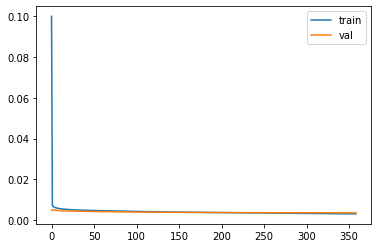

In [34]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

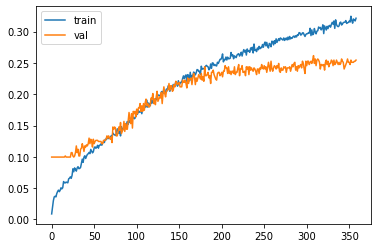

In [35]:
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='val')
plt.legend()
plt.show()

In [36]:
def build_dict():
    df = pd.read_csv('data/test.csv')
    dict_df = pd.DataFrame()
    answers = []
    indices = []
    for column in df.columns:
        answers.append(column)
        indices.append(df.columns.get_loc(column)-4)
    dict_df['answer'] = answers[4:]
    dict_df['index'] = indices[4:]
    dict_df.to_csv('data/dict.csv', index=False)

In [37]:
_, accuracy = evaluate(x_train, y_train, model_dir)
accuracy

158/158 [==============================] - 1s 8ms/step - loss: 0.0030 - categorical_accuracy: 0.3224


0.3224465548992157

In [38]:
test_df = pd.read_csv('data/test.csv')
dict_df = pd.read_csv('data/dict.csv')
f = open('data/train_original.json', "r")
answers_file = json.load(f)
f.close()

## NUMBERS

In [39]:
number_df = test_df[test_df.answer_type == 'number']
print(number_df.shape[0])

ty = []
for row in number_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, tyy = build_model_input(number_df)
ty_pred = predict(tx, model_dir)
print('VQA metric - ' + str(vqa_metric(ty, ty_pred)))
_, accuracy = evaluate(tx, tyy, model_dir)
print('Accuracy - ' + str(accuracy))

5
1/1 [==============================] - 0s 95ms/step
VQA metric - 0.06666666666666667
1/1 [==============================] - 0s 93ms/step - loss: 0.0030 - categorical_accuracy: 0.2000
Accuracy - 0.20000000298023224


## YES/NO

In [40]:
yesno_df = test_df[test_df.answer_type == 'yes/no']
print(yesno_df.shape[0])

ty = []
for row in yesno_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, tyy = build_model_input(yesno_df)
ty_pred = predict(tx, model_dir)
print('VQA metric - ' + str(vqa_metric(ty, ty_pred)))
_, accuracy = evaluate(tx, tyy, model_dir)
print('Accuracy - ' + str(accuracy))

49
2/2 [==============================] - 0s 8ms/step
VQA metric - 0.6394557823129252
2/2 [==============================] - 0s 7ms/step - loss: 0.0013 - categorical_accuracy: 0.4898
Accuracy - 0.4897959232330322


## OTHER

In [41]:
other_df = test_df[test_df.answer_type == 'other']
print(other_df.shape[0])

ty = []
for row in other_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, tyy = build_model_input(other_df)
ty_pred = predict(tx, model_dir)
print('VQA metric - ' + str(vqa_metric(ty, ty_pred)))
_, accuracy = evaluate(tx, tyy, model_dir)
print('Accuracy - ' + str(accuracy))

568
18/18 [==============================] - 0s 8ms/step
VQA metric - 0.3339201877934274
18/18 [==============================] - 0s 8ms/step - loss: 0.0025 - categorical_accuracy: 0.2412
Accuracy - 0.24119718372821808


## TOTAL

In [42]:
ty = []
for row in test_df.values:
    answers = []
    for answer_with_confidence in [question['answers'] for question in answers_file if int(question['image'].removeprefix('VizWiz_train_').removesuffix('.jpg')) == row[1]][0]:
        answer = answer_with_confidence['answer']
        vector = [0]*2327
        try:
            index = dict_df[dict_df.answer == answer]['index'].values[0]
            vector[index] = 1
        except:
            pass
        answers.append(vector)
    ty.append(answers)

tx, tyy = build_model_input(test_df)
ty_pred = predict(tx, model_dir)
print('VQA metric - ' + str(vqa_metric(ty, ty_pred)))
_, accuracy = evaluate(tx, tyy, model_dir)
print('Accuracy - ' + str(accuracy))

20/20 [==============================] - 0s 8ms/step
VQA metric - 0.356303418803419
20/20 [==============================] - 0s 8ms/step - loss: 0.0024 - categorical_accuracy: 0.2612
Accuracy - 0.26121795177459717
